# Twitter sentiment analysis

### Overview
This is an entity-level sentiment analysis dataset of twitter. Given a message and an entity, the task is to judge the sentiment of the message about the entity. There are three classes in this dataset: Positive, Negative and Neutral. We regard messages that are not relevant to the entity (i.e. Irrelevant) as Neutral.

In [22]:
#importing libraries 
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import string
import nltk
import joblib

import sys
import os
from pathlib import Path
sys.path.append(str(Path('/Users/sultanbeishenkulov/Programming/Projects/Twitter_semtiment_analysis/preprocessing.py').parent))
from preprocessing import Preprocessing



ModuleNotFoundError: No module named 'wordcloud'

In [2]:
#Reading datasets and concating for data cleaning
train_data = pd.read_csv('twitter_training.csv')
validation_data = pd.read_csv('twitter_validation.csv')
data = pd.concat([train_data, validation_data], ignore_index=False)
data.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,",3364,Facebook,Irrelevant,"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣"
0,2401.0,Borderlands,Positive,I am coming to the borders and I will kill you...,NaN,NaN,NaN,NaN
1,2401.0,Borderlands,Positive,im getting on borderlands and i will kill you ...,NaN,NaN,NaN,NaN
2,2401.0,Borderlands,Positive,im coming on borderlands and i will murder you...,NaN,NaN,NaN,NaN
3,2401.0,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,NaN,NaN,NaN,NaN
4,2401.0,Borderlands,Positive,im getting into borderlands and i can murder y...,NaN,NaN,NaN,NaN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75680 entries, 0 to 998
Data columns (total 8 columns):
 #   Column                                                                                                                                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                                                                                                                                              --------------  -----  
 0   2401                                                                                                                                                                                                                                                74681 non-null  float64
 1   Borderlands                                                           

In [4]:
# Cleaning the column names
columns_to_drop = ['2401', '3364', 'Facebook', 'Irrelevant',
                   'I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣']
data = data.drop(columns_to_drop, axis=1)

#Renaming data columns
data = data.rename(columns={"Borderlands": "branch", "Positive": "Sentiment", 'im getting on borderlands and i will murder you all ,': 'Tweet'})

In [6]:
data.head()

,branch,Sentiment,Tweet
0,Borderlands,Positive,I am coming to the borders and I will kill you...
1,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,Borderlands,Positive,im coming on borderlands and i will murder you...
3,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,Borderlands,Positive,im getting into borderlands and i can murder y...


In [7]:
#Checking missing values
print(data.isnull().sum())
#Dropping missing values
data.dropna(inplace=True)

branch        999
Sentiment     999
Tweet        1685
dtype: int64


In [8]:
data.isnull().sum()
#now we do not have any missing values, I deleted them
#because my goal is to work on nlp techniques

branch       0
Sentiment    0
Tweet        0
dtype: int64

In [9]:
#Now let's check for dublicates
data.duplicated().sum()

3038

In [10]:
#Removing the dublicates
data = data.drop_duplicates()
data.duplicated().sum()

0

### Data visualization

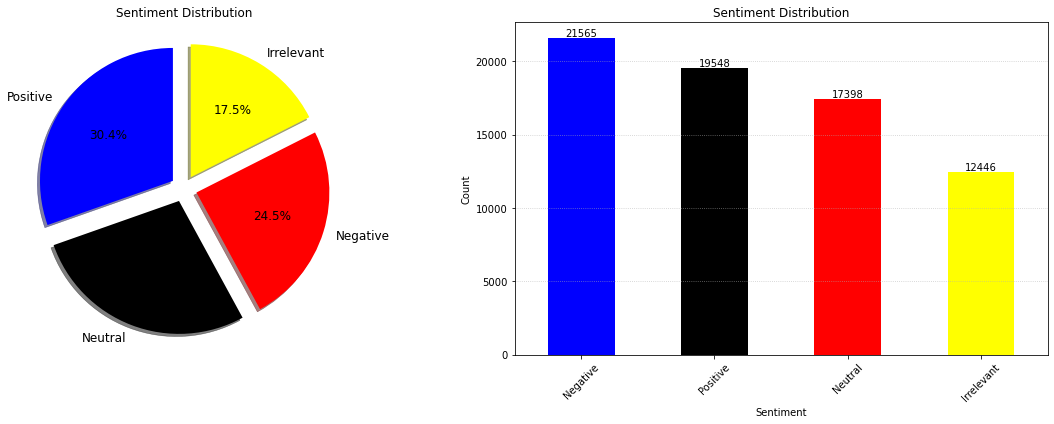

In [11]:
#Pie & Bar Plot
#custom colors
colors = ['blue', 'black', 'red', 'yellow']

#Create subplots
fig, axs = plt.subplots(1, 2, figsize= (16,6))

#Plotting pie chart for sentiment distribution with our colors
axs[0].pie(data['Sentiment'].value_counts(), 
           labels = data["Sentiment"].unique(), 
           autopct = '%1.1f%%', 
           startangle=90, 
           wedgeprops={'linewidth': 0.5}, 
           textprops = {'fontsize' : 12}, 
           explode = [0.1, 0.1, 0.1, 0.1], 
           colors = colors, shadow = True)
axs[0].set_title('Sentiment Distribution')

#Plotting bar plot for sentiment distibution
axs[1] = data['Sentiment'].value_counts().plot(kind = 'bar', color=colors,
                                               ax=axs[1])
axs[1].set_title("Sentiment Distribution")
axs[1].set_xlabel("Sentiment")
axs[1].set_ylabel("Count")
axs[1].tick_params(axis = 'x', rotation=45)
axs[1].grid(axis='y', linestyle= ':', alpha=0.7)

#Add text on top of each bar in the bar plot

for p in axs[1].patches:
    axs[1].annotate(str(p.get_height()), 
                    (p.get_x() + p.get_width() /2., p.get_height()), 
                    ha = 'center', 
                    va = 'center', 
                    xytext=(0, 5), 
                    textcoords = 'offset points')

plt.tight_layout()
plt.show()



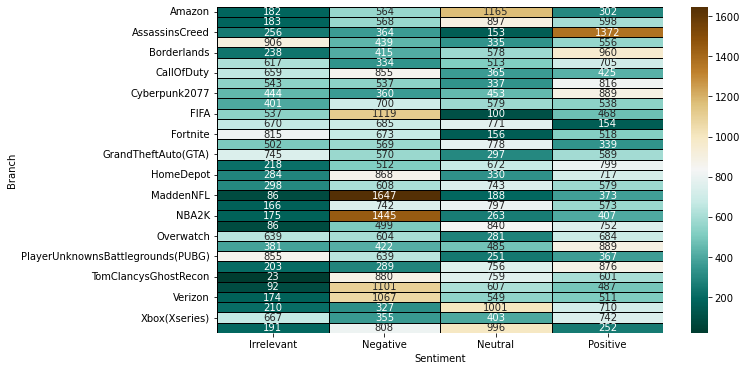

In [12]:
#Cross table
plt.figure(figsize=(10, 6))
count_table = pd.crosstab(index=data['branch'], columns = data['Sentiment'])
sns.heatmap(count_table, cmap = 'BrBG_r', annot = True, fmt = 'd', linewidths = 0.5, linecolor = 'black')
plt.xlabel('Sentiment')
plt.ylabel('Branch')
plt.show()

In [13]:
#Display min and max values for each sentiment for each branch
#Some statistics about sentiments across different branches
for sentiment in count_table.columns:
    min_branch = count_table[sentiment].idxmin()
    max_branch = count_table[sentiment].idxmax()
    min_val = count_table[sentiment].min()
    max_val = count_table[sentiment].max()
    print(f"Sentiment '{sentiment}' : ")
    print(f"  Minimum value '{min_val}' at Branch '{min_branch}'")
    print(f"  Maximum value '{max_val}' at Branch '{max_branch}'\n")

Sentiment 'Irrelevant' : 
  Minimum value '23' at Branch 'TomClancysGhostRecon'
  Maximum value '906' at Branch 'Battlefield'

Sentiment 'Negative' : 
  Minimum value '289' at Branch 'RedDeadRedemption(RDR)'
  Maximum value '1647' at Branch 'MaddenNFL'

Sentiment 'Neutral' : 
  Minimum value '100' at Branch 'FIFA'
  Maximum value '1165' at Branch 'Amazon'

Sentiment 'Positive' : 
  Minimum value '154' at Branch 'Facebook'
  Maximum value '1372' at Branch 'AssassinsCreed'



In [14]:
#Cloud plot of Branch
#Convert branches to a single string
branches_text = ''.join(count_table.index)

#Create word cloud
wordcloud = WordCloud(width=900, height = 500, background_color = 'black').generate(branches_text)

#Plot it 
plt.figure(figsize= (10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Branches')
plt.axis('off')
plt.show()

NameError: name 'WordCloud' is not defined

In [16]:
# Concatenate all tweets into a single string
all_tweets_text = ' '.join(data['Tweet'])

# Create word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_tweets_text)

# Plot word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Tweets')
plt.axis('off')
plt.show()

NameError: name 'WordCloud' is not defined

In [21]:
#Preprocessing data: 
df_processed = preprocess_text(data)

NameError: name 'preprocess_text' is not defined